In [1]:
from glob import glob
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import pandas as pd

# statistics
from astropy.stats import biweight_location, biweight_scale, sigma_clipped_stats
from scipy.stats import median_abs_deviation

# configuration
np.set_printoptions(linewidth=120) # para que se vea
plt.rcParams["image.cmap"] = "gray" # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.rcParams["image.origin"] = "lower"

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

In [2]:
files = glob("data/m92/*.fit")
files

['data/m92/m92_3.fit',
 'data/m92/m92_2.fit',
 'data/m92/m92_1.fit',
 'data/m92/m92_5.fit',
 'data/m92/m92_4.fit',
 'data/m92/m92_6.fit',
 'data/m92/m92_7.fit']

# M-92, imágenes desde KPNO 

Para cada parte del ejercicio, agregue tantas celdas de código o de Markdown como considere necesario.

## 1) Información

Obtenga el tipo de imagen, el objeto, y después el filtro de cada una de las imágenes en la carpeta `data/m92`.

Organice esta información como crea conveniente, ya sea en diferentes variables, en diccionarios, o en un DataFrame.

¿Por qué el bias no tiene filtro asignado?

In [3]:
for file in files:
    print(fits.info(file))

Filename: data/m92/m92_3.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92/m92_2.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92/m92_1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92/m92_5.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92/m92_4.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92/m92_6.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      43   (352, 512)   int16   
None
Filename: data/m92/m92_7.fit
No.    Name

In [4]:

fits.getheader("data/m92/m92_1.fit")

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                   16  /  FITS BITS/PIXEL                              
NAXIS   =                    2  /  NUMBER OF AXES                               
NAXIS1  =                  352  /                                               
NAXIS2  =                  512  /                                               
BSCALE  =       1.0000000000E0  /  REAL = TAPE*BSCALE + BZERO                   
BZERO   =       0.0000000000E0  /                                               
OBJECT  = 'ave of 25 bias'      /                                               
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '17-09-93'            /                                               
IRAFNAME= 'm92001.imh'          /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           7.130000E2  /  DATA MAX                                     
IRAF-MIN=           4.940000

In [5]:
fits.getheader("data/m92/m92_2.fit")

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                   16  /  FITS BITS/PIXEL                              
NAXIS   =                    2  /  NUMBER OF AXES                               
NAXIS1  =                  352  /                                               
NAXIS2  =                  512  /                                               
BSCALE  =       1.0000000000E0  /  REAL = TAPE*BSCALE + BZERO                   
BZERO   =       0.0000000000E0  /                                               
OBJECT  = 'ave of  5 Harris B Sept 1 1987'  /                                   
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '17-09-93'            /                                               
IRAFNAME= 'm92006.imh'          /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           5.581000E3  /  DATA MAX                                     
IRAF-MIN=           4.900000

In [6]:
fits.getheader("data/m92/m92_3.fit")

SIMPLE  =                    T  /  FITS STANDARD                                
BITPIX  =                   16  /  FITS BITS/PIXEL                              
NAXIS   =                    2  /  NUMBER OF AXES                               
NAXIS1  =                  352  /                                               
NAXIS2  =                  512  /                                               
BSCALE  =       1.0000000000E0  /  REAL = TAPE*BSCALE + BZERO                   
BZERO   =       0.0000000000E0  /                                               
OBJECT  = 'ave of  5 V filter dome flat  1-sept-87'  /                          
ORIGIN  = 'KPNO-IRAF'           /                                               
DATE    = '17-09-93'            /                                               
IRAFNAME= 'm92007.imh'          /  NAME OF IRAF IMAGE FILE                      
IRAF-MAX=           5.985000E3  /  DATA MAX                                     
IRAF-MIN=           4.920000

## 2) Visualización

Importe todas las imágenes con `fits.getdata`. Organice estas imágenes como considere necesario, siguendo el mismo esquema que usó en el primer punto.

Haga un subplot para visualizar todas las imágenes. Puede usar la función `quantile_imshow` que usamos para el primer laboratorio.

In [7]:
import re
from scipy.signal import find_peaks

In [8]:
headers = [fits.getheader(f) for f in files]
def get_row(header):
    image_type = header['OBJECT']
    if re.search("^(.+)? B( |)", image_type):
        row = 0
    elif re.search("^(.+)? ?V( |)", image_type):
        row = 1
    elif re.search("^(.+) bias ?(.*)?$", image_type):
        row = 2
    return row


In [9]:
images = [fits.getdata(f) for f in files]
row_counts = [0, 0, 0]

In [10]:
sum_y = [image.sum(axis=0) for image in images]
sum_x = [image.sum(axis=1) for image in images]

def get_limit(header, y_data):
    for i in range(len(header)):
        image_type = header[i]['OBJECT']
        if re.search("^(.+) bias ?(.*)?$", image_type):
            peaks, _ = find_peaks(y_data[i], prominence = 3)
            limit = peaks[-1]
            break
    return limit
    

In [11]:
get_limit(headers, sum_y)

348

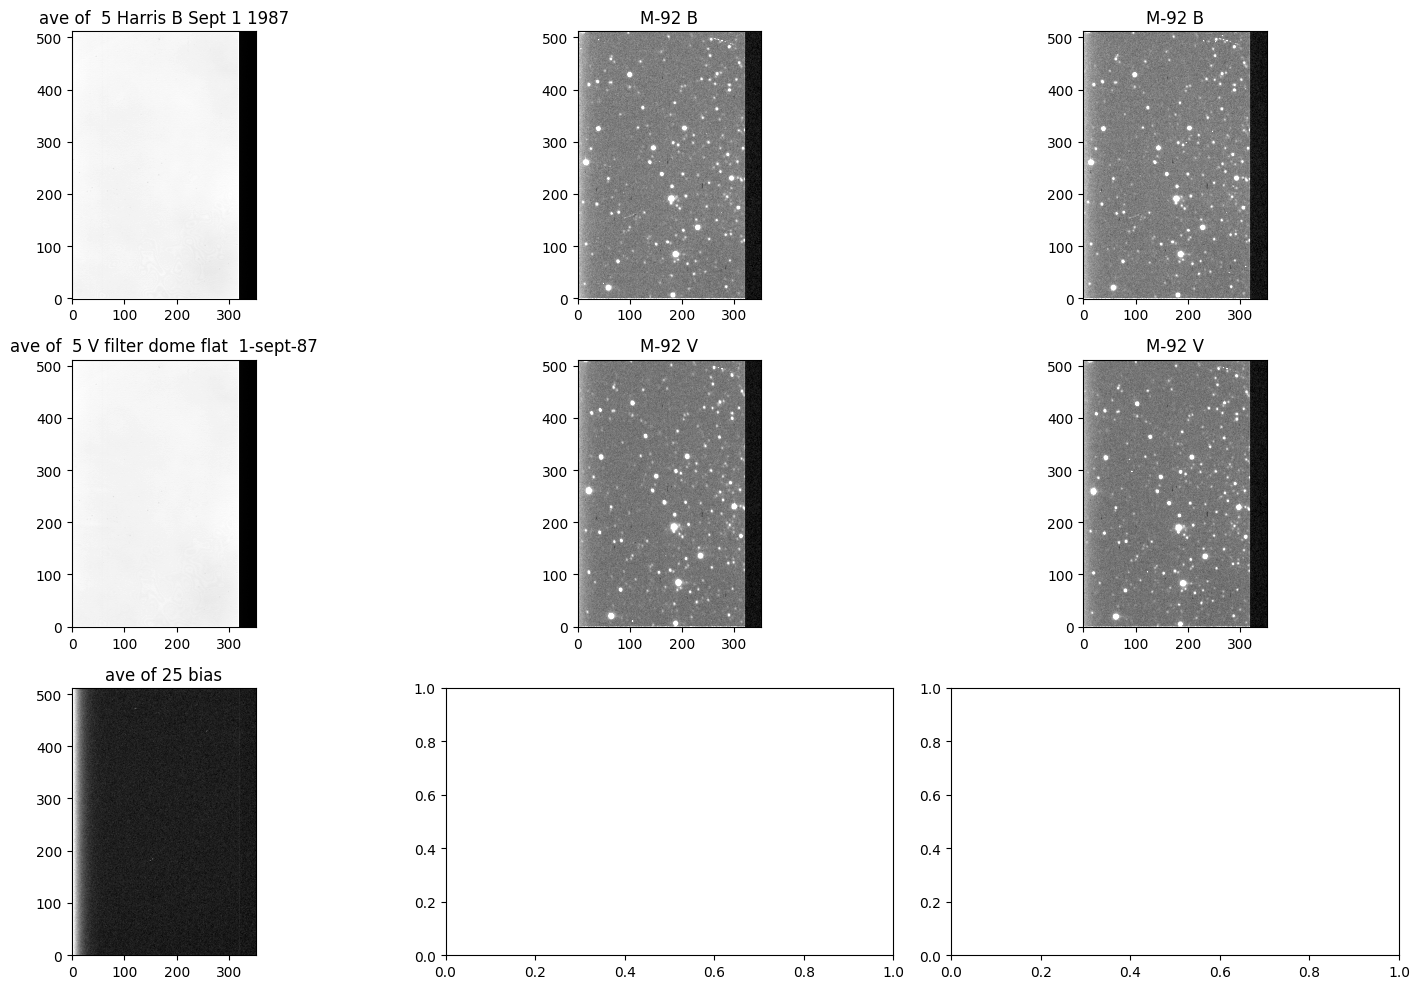

In [12]:
#Gráficas
fig,ax = plt.subplots(nrows = 3, ncols=3,figsize=(15,10))
for i,image in enumerate(images):
    row = get_row(headers[i])
    plt.sca(ax[row, row_counts[row]])
    plt.title(headers[i]['OBJECT'])
    row_counts[row] += 1
    quantile_imshow(image)

plt.tight_layout()

## 3) Recorte

Estas imágenes tienen algo llamado _"overscan"_. Discuta brevemente qué entiende de este término, según la explicación del profesor.

### 3.A) detalle del overscan

Grafique el promedio de los pixeles en X (`np.mean(...,axis=0)`) contra los pixeles en Y (`NAXIS1`).
Haga un zoom de su gráfica de promedio a la región de overscan. Para esto puede usar `plt.xlim` y `plt.ylim`.

Determine la región de overscan: píxel inicial y pixel final. Guarde esta información como lo considere conveniente.

Obtenga estadísticas (localización y escala) de las regiones de overscan de al menos dos de las imágenes. 
¿Qué medida de localización y de escala va a usar, y por qué?

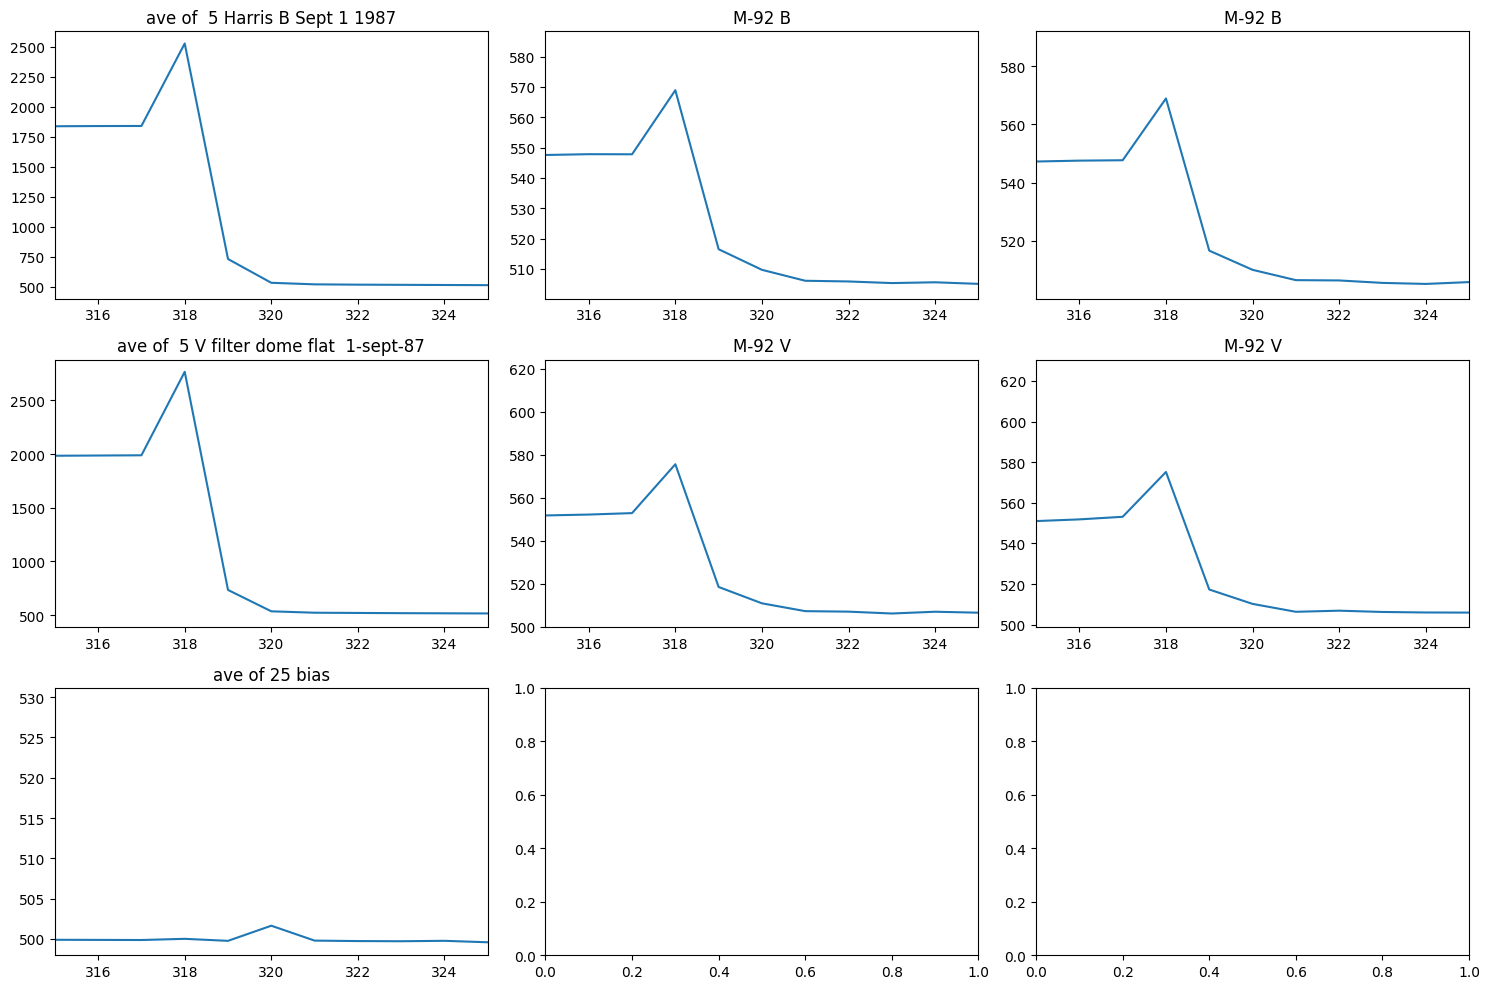

In [13]:
fig,ax = plt.subplots(nrows = 3, ncols=3,figsize=(15,10))
row_counts = [0, 0, 0]
limit = get_limit(headers, sum_y) + 1
for i,image in enumerate(images):
    row = get_row(headers[i])
    plt.sca(ax[row, row_counts[row]])
    plt.plot(np.mean(images[i], axis = 0))
    plt.xlim(315, 325)
    plt.title(headers[i]['OBJECT'])
    row_counts[row] += 1
    

plt.tight_layout()

### 3.B) imágenes recortadas

Remueva la región de overscan (determinada en el punto anterior) de todas las imágenes. No las modifique, sino que haga copias y guarde las imágenes recortadas como considere.

In [14]:
np.shape(images)
images = np.array(images)
trimmed_images = images[:, 2:-2, :317]

In [21]:
len(trimmed_images)

7

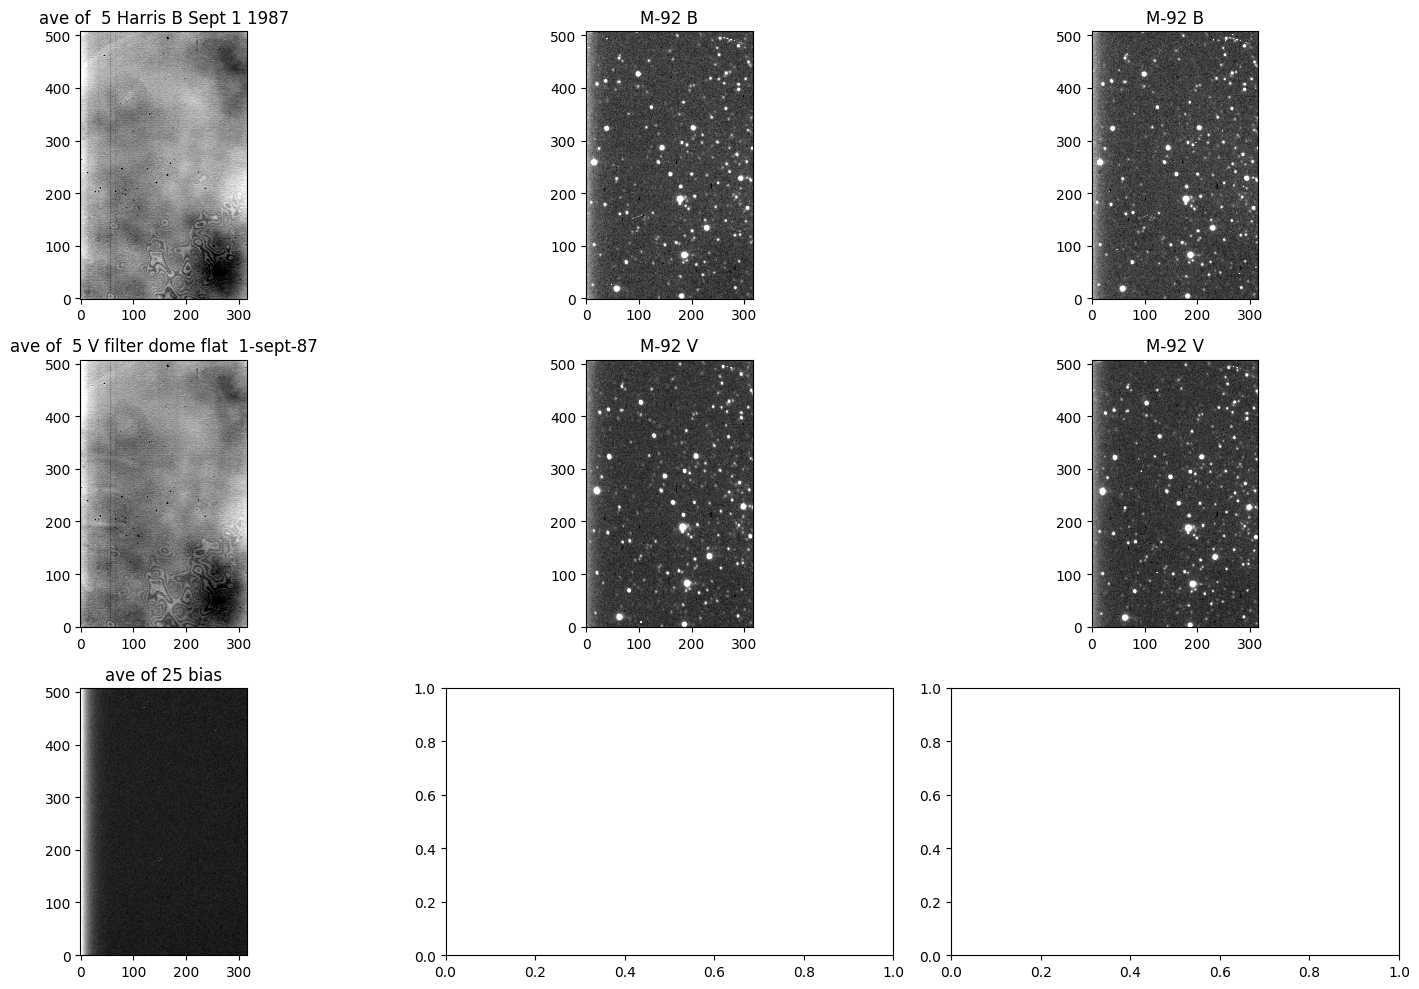

In [22]:
#Gráficas
fig,ax = plt.subplots(nrows = 3, ncols=3,figsize=(15,10))
row_counts = [0,0,0]
for i,image in enumerate(trimmed_images):
    row = get_row(headers[i])
    plt.sca(ax[row, row_counts[row]])
    plt.title(headers[i]['OBJECT'])
    row_counts[row] += 1
    quantile_imshow(image)

plt.tight_layout()

## 4) Bias

Remueva la imagen de bias de todas las imágenes, sean flat o ciencia. De nuevo, no las modifique, haga copias, y organice como considere.

In [79]:

def remove_bias(headers, trimmed_images):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
    row_c = [0, 0]
    bias_images = []
    for i, trimmed_image in enumerate(trimmed_images):
        header = headers[i]
        image_type = header['OBJECT']
        if "bias" in image_type.lower():
            bias_images.append(trimmed_image)
            continue

    for i, trimmed_image in enumerate(trimmed_images):
        header = headers[i]
        image_type = header['OBJECT']
        if "bias" not in image_type.lower():
            if re.search("^.+?B( |$)", image_type):
                row_ = 0
            elif re.search("^.+?V( |$)", image_type):
                row_ = 1
            else:
                continue
            
            print(row_c, row_)
            plt.sca(ax[row_, row_c[row_]])
            plt.title(headers[i]['OBJECT'])
            quantile_imshow(trimmed_image)
            row_c[row_] += 1

    plt.tight_layout()

In [75]:
len(trimmed_images[1])

508

[0, 0] 1
[0, 1] 0
[1, 1] 1
[1, 2] 1
[1, 3] 0
[2, 3] 0


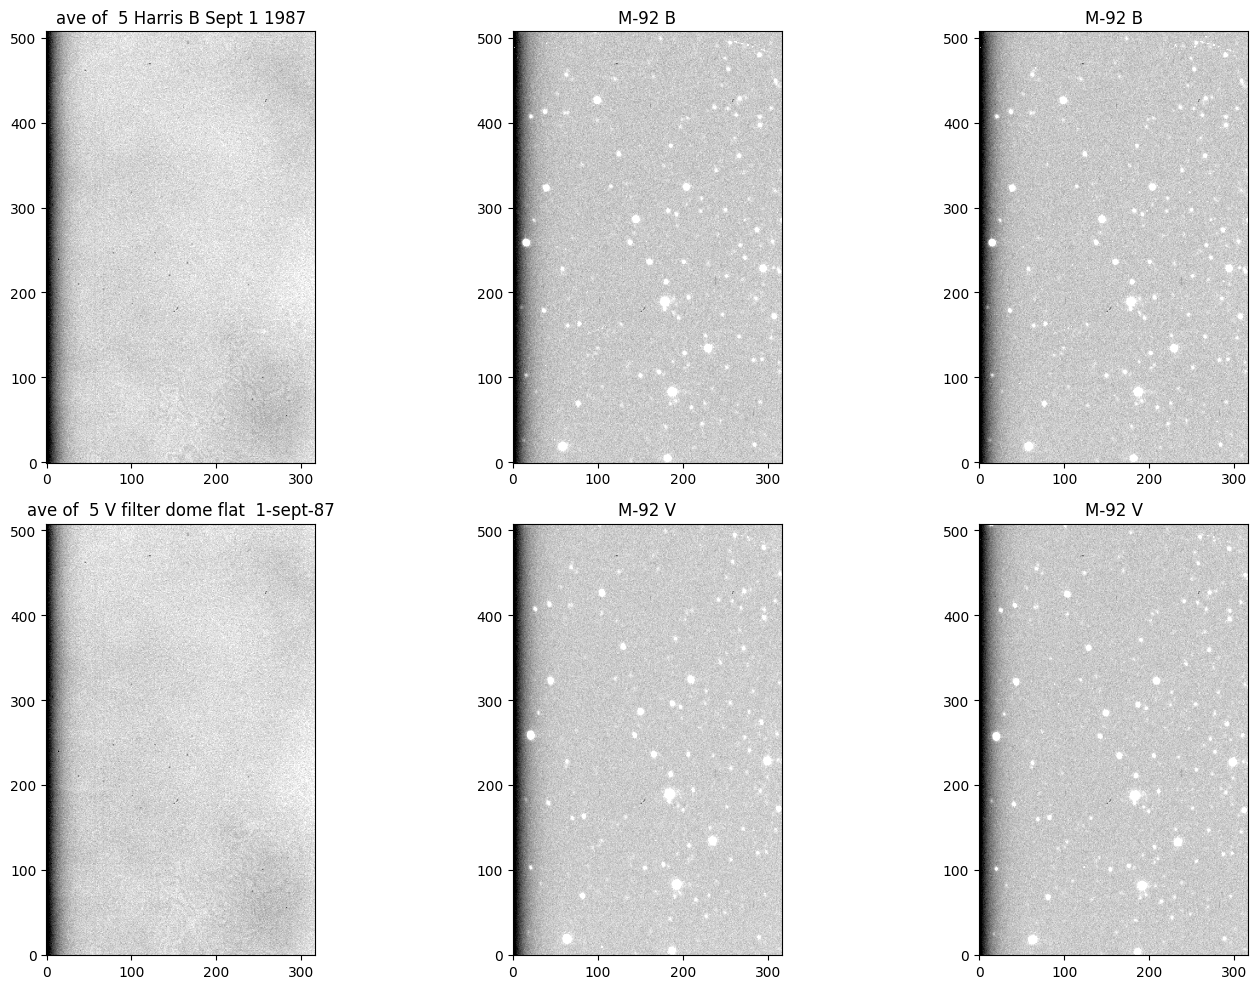

In [80]:
remove_bias(headers, trimmed_images)

### 4.extra) comparación con el overscan

Compare los valores del bias con las estádisticas que obtuvo del overscan, y comente.

numpy.ndarray

## 5) Flat

Normalice las imágenes flat (de nuevo, ¿qué medida de localización va a usar, y por qué?), y aplique el flat a las imágenes ciencia, teniendo cuidado de usar el filtro apropiado.

In [81]:
science = [trimmed_images[2], trimmed_images[5], trimmed_images[6]]
flat = [trimmed_images[0], trimmed_images[3], trimmed_images[4]]

In [105]:
flat_normalization_values = [np.median(flat) for flat in flat]
normalized_flats = [flat / norm_val for flat, norm_val in zip(flat, flat_normalization_values)]

corrected_science_images = [science / normalized_flat for science, normalized_flat in zip(science, normalized_flats)]


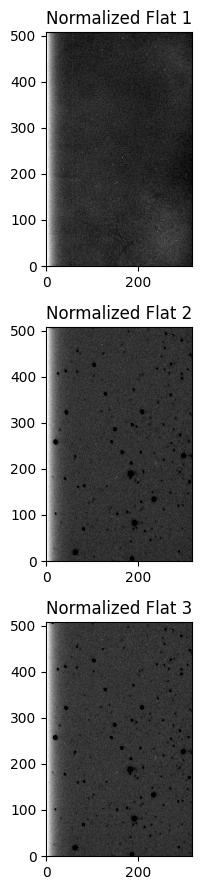

In [107]:
fig, ax = plt.subplots(nrows=len(normalized_flats), ncols=1, figsize=(10, 3 * len(normalized_flats)))
for i, normalized_flat in enumerate(normalized_flats):
    plt.sca(ax[i])
    plt.title(f"Normalized Flat {i+1}")
    quantile_imshow(normalized_flat)
plt.tight_layout()

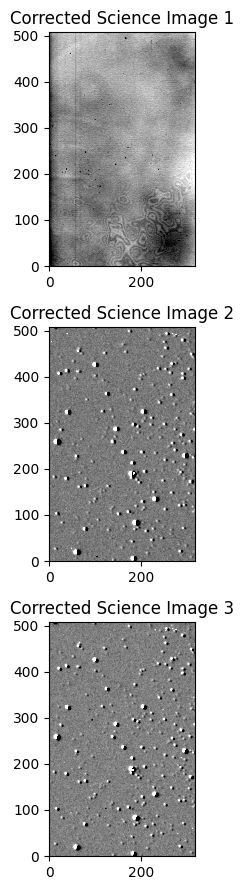

In [109]:
fig, ax_ = plt.subplots(nrows=len(corrected_science_images), ncols=1, figsize=(10, 3 * len(corrected_science_images)))
for i, corrected_image in enumerate(corrected_science_images):
    plt.sca(ax_[i])
    plt.title(f"Corrected Science Image {i+1}")
    quantile_imshow(corrected_image)
plt.tight_layout()

In [92]:
normalized_flats[1]

array([[1.05720572, 1.05188852, 1.0489549 , ..., 0.99816648, 1.00348368, 0.99339934],
       [1.06784012, 1.04730473, 1.04913825, ..., 0.99724972, 0.99193253, 1.0003667 ],
       [1.05977264, 1.0546388 , 1.04785479, ..., 1.00238357, 1.00898423, 0.99798313],
       ...,
       [1.05903924, 1.04822149, 1.05188852, ..., 0.9950495 , 1.00476714, 1.00165017],
       [1.06160616, 1.05317198, 1.05078841, ..., 0.99724972, 0.9996333 , 0.99633297],
       [1.05977264, 1.04693803, 1.04162083, ..., 0.99724972, 0.9950495 , 1.00165017]])

## 6) Guardar las imágenes calibradas

Primero, copie los headers originales de las imágenes ciencia, y agregue un comentario describiendo **_muy brevemente_** el proceso de reducción realizado.

Para guardar sus resultados en formato fits, para cada imagen ciencia calibrada, use la función `fits.PrimaryHDU`. 
Use los headers que contienen su comentario.

Una vez obtenido el objeto `PrimaryHDU`, use el método `hdu.writeto`. Ponga un nombre descriptivo, pero corto, a las imágenes resultantes.

### 6.extra) 

Cree un subplot con las imágenes ciencia calibradas, con barras de color indicando las cuentas.

# Alcyone, desde el observatorio uniandes

En la carpeta `data/uniandes` hay una imagen de Alcyone, en la región de las Pléyades, junto con sus imágenes de calibración: 9 bias, 0 darks, y 3 flats.

## 1) Main-flat, main-bias, main-dark

Obtenga de nuevo los tipos de las imágenes. Promedie todos los flats, todos los bias, y todos los darks, para obtener las imágenes "master", o "main".

### 1.extra)

Usando `astropy.modeling` [(documentación aquí)](https://docs.astropy.org/en/stable/modeling/index.html), realice un model 2D del main-bias. 

In [ ]:
from astropy.modeling.models import custom_model
from astropy.modeling import fitting
fitter = fitting.LevMarLSQFitter()

Para guiarse en esto, grafique los primedios de los pixeles en X y en Y. ¿Qué función se le ocurre que se comporta así?

In [ ]:
def bias_model(x,y,/,a=1,b=1,c=1,d=1):
    pass
    #return su modelo aquí
BiasModel = custom_model(bias_model)
bias_model = BiasModel()

Use el `fitter` para ajustar la imagen. Va a necesitar una grilla de pixeles como input al modelo. Yo recomiendo usar:

```python
X,Y = np.mgrid[:x_px_max,:y_px_max]
```

Donde `px_max` son la cantidad de pixeles en X y en Y.

Se recomienda analizar los residuales del modelo `main_bias - bias_model(X,Y)`; deberían ser Gaussianos y tener media cero, y su imagen debería ser plana.

¿Qué diferencia hay entre restar la imagen bias y restar el modelo, si este modelo es bueno?

## 2) Reducción

Ya que esta imagen no tiene overscan, no necesita ser recortada. Aplique directamente la calibración, incluyendo el main-dark.

Guarde la imagen calibrada en un .fits como en el ejercicio anterior.

In [ ]:
files_uniandes = glob("data/uniandes/*.fit")
files_uniandes

['data/uniandes/d8.fit',
 'data/uniandes/d9.fit',
 'data/uniandes/b8.fit',
 'data/uniandes/b9.fit',
 'data/uniandes/Flat_3.fit',
 'data/uniandes/b4.fit',
 'data/uniandes/b5.fit',
 'data/uniandes/Flat_2.fit',
 'data/uniandes/b7.fit',
 'data/uniandes/b6.fit',
 'data/uniandes/Flat_1.fit',
 'data/uniandes/Alcyone.fit',
 'data/uniandes/b2.fit',
 'data/uniandes/b3.fit',
 'data/uniandes/b1.fit',
 'data/uniandes/d7.fit',
 'data/uniandes/d6.fit',
 'data/uniandes/d4.fit',
 'data/uniandes/d5.fit',
 'data/uniandes/d1.fit',
 'data/uniandes/d2.fit',
 'data/uniandes/d3.fit']

In [ ]:

images_uniandes = [fits.getdata(f) for f in files_uniandes]
row_counts = [0, 0, 0]

In [ ]:
headers = [fits.getheader(f) for f in files_uniandes]



In [ ]:
headers[3]

SIMPLE  =                    T /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                  765 /                                                
NAXIS2  =                  510 /                                                
OBJECT  = 'BIAS    '                                                            
TELESCOP= 'Meade LX200'                                                         
INSTRUME= 'SBIG ST-402'                                                         
OBSERVER= 'Maria Gracia Batista'                                                
DATE-OBS= '2024-02-10T02:26:47.000' / GMT START OF EXPOSURE [WIN]               
BZERO   = +3.276800000000E+004 /                                                
BSCALE  = +1.000000000000E+000 /                                                
EXPTIME = +4.000000000000E-0

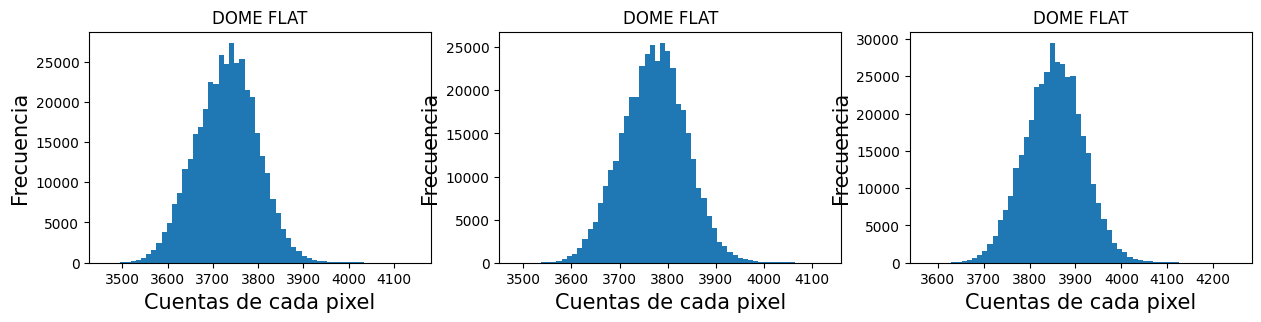

In [ ]:
fig,ax = plt.subplots(nrows = 1, ncols=3,figsize=(15,3))

cols = 0
for i,image in enumerate(images_uniandes):
    image_type = headers[i]['OBJECT']
    if "FLAT" in image_type:
        flattened = image.ravel()
        plt.sca(ax[cols])
        plt.title(headers[i]['OBJECT'])
        plt.hist(flattened,bins=60)
        plt.xlabel("Cuentas de cada pixel",fontsize=15)
        plt.ylabel("Frecuencia",fontsize=15)
        cols +=1

In [ ]:
for i,image in enumerate(images_uniandes):
    image_type = headers[i]['OBJECT']
    flattened = image.ravel()
    if "FLAT" in image_type:
        mean, var, median = np.mean(flattened), np.var(flattened), np.median(flattened)
        


In [ ]:
flattened = images[0].ravel()
flattened.shape

(390150,)

Text(0, 0.5, 'Frecuencia')

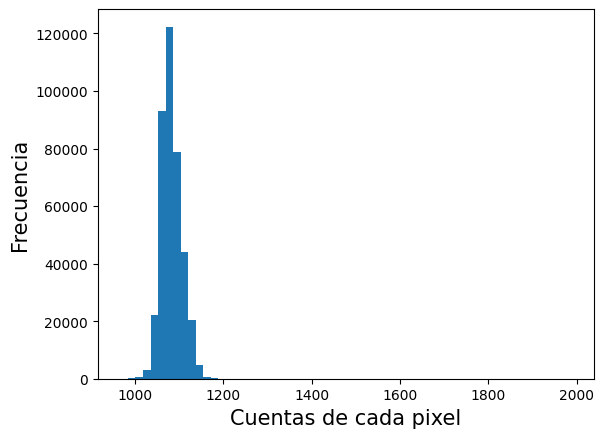

In [ ]:
plt.hist(flattened,bins=60)
plt.xlabel("Cuentas de cada pixel",fontsize=15)
plt.ylabel("Frecuencia",fontsize=15)